In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [41]:
# Set colors
class color:
    GREEN, RED = '\033[92m', '\033[91m'
    BOLD, UNDERLINE, END = '\033[1m', '\033[4m', '\033[0m'
    GREEN_BOLD = GREEN + BOLD
    RED_BOLD = RED + BOLD
    GREEN_BOLD_UND = GREEN_BOLD + UNDERLINE

rb, gb,  = color.RED_BOLD, color.GREEN_BOLD
gbu, end = color.GREEN_BOLD_UND, color.END

In [42]:
data = pd.read_csv('stock_data.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Company,Ticker
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,72.876099,135480400,Apple,AAPL
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.167618,146322800,Apple,AAPL
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,72.742645,118387200,Apple,AAPL
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.400551,108872000,Apple,AAPL
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,73.565201,132079200,Apple,AAPL


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9328 entries, 0 to 9327
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9328 non-null   object 
 1   Open       9328 non-null   float64
 2   High       9328 non-null   float64
 3   Low        9328 non-null   float64
 4   Close      9328 non-null   float64
 5   Adj Close  9328 non-null   float64
 6   Volume     9328 non-null   int64  
 7   Company    9328 non-null   object 
 8   Ticker     9328 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 656.0+ KB


In [44]:
# Convert the type of "Date" column into date-time
data["Date"] = pd.to_datetime(data["Date"])
print (data.dtypes)

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
Company              object
Ticker               object
dtype: object


In [45]:
# Add the "Year", 'Month' and "Day" columns
data["Year"] = data["Date"].apply(lambda x : str(x)[:4])
data["Month"] = data["Date"].apply(lambda x : str(x)[5:7])
data["Day"] = data["Date"].apply(lambda x : str(x)[8:10])

data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,Company,Ticker,Year,Month,Day
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,72.876099,135480400,Apple,AAPL,2020,01,02
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.167618,146322800,Apple,AAPL,2020,01,03
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,72.742645,118387200,Apple,AAPL,2020,01,06


In [46]:
# Print the number of trading days
print(f'{rb}Total number of trading days: {end}{gbu}{data.shape[0]}{end}')
print(f'{rb}Total number of fields: {end}{gbu}{data.shape[1]}{end}')
print('\n')

# Check the Null and NA values
print(f'{rb}Null values: {end}{gbu}{data.isnull().values.sum()}{end}')
print(f'{rb}NA values: {end}{gbu}{data.isna().values.any()}{end}')

Total number of trading days: 9328
Total number of fields: 12


Null values: 0
NA values: False


In [47]:
# Create a new dataframe with only the Open column and convert it into a NumPy array
data = data['Open'].values

# Reshape the data
data = data.reshape(-1, 1)

In [48]:
# Split the data into training and testing sets
dataset_train = np.array(data[:int(data.shape[0]*0.8)])
dataset_test = np.array(data[int(data.shape[0]*0.8):])

In [49]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))

dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

In [50]:
# Create the function that will help us to create the datasets
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [51]:
# Create the training and testing data by calling our function for each one
x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)

In [52]:
# Reshape the data to make it a 3D array in order to use it in LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [53]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [54]:
# Summary of the model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 50, 96)         │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50, 96)         │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50, 96)         │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 96)             │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,065 (1015.88 KB)

 Trainable params: 260,065 (1015.88 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Reshape the feature for the LSTM layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # for expecting 3 dimentions, not 2
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [56]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [71]:
# Define modifiable training hyperparameters
epochs = 20
batch_size = 256

# Save the model and start the training
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)
model.save('stock_prediction.keras')

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 482ms/step - loss: 4.8543e-04
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 485ms/step - loss: 3.8087e-04
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 484ms/step - loss: 4.1778e-04
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 379ms/step - loss: 5.0010e-04
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 253ms/step - loss: 3.2484e-04
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 463ms/step - loss: 3.5736e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 532ms/step - loss: 5.4628e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 493ms/step - loss: 3.1901e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 476ms/step - loss: 3.4112e-04
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 486ms/step - loss: 3.3589e-04
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 518ms/step - loss: 3.4848e-04
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 535ms/step - loss: 3.9696e-04
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 523ms/step - loss: 4.6147e-04
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 511ms/step - loss:

In [75]:
# Load the model
model = load_model('stock_prediction.keras')

In [76]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


In [77]:
mse = mean_squared_error(y_test_scaled, predictions)
print(f"Mean Squared Error (MSE): {mse}")

mae = mean_absolute_error(y_test_scaled, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

r2 = r2_score(y_test_scaled, predictions)
print(f"R² Score: {r2}")

# Calculate accuracy with a tolerance level
tolerance = 0.10  # 10%

accuracy = np.mean(np.abs((y_test_scaled - predictions) / y_test_scaled) <= tolerance)
print(f"Accuracy within {tolerance*100}% tolerance: {accuracy * 100:.2f}%")


Mean Squared Error (MSE): 7.895559755740165
Mean Absolute Error (MAE): 2.178216232602292
R² Score: 0.9915729958105116
Accuracy within 10.0% tolerance: 99.72%


In [78]:
print(y_test_scaled)

[[ 73.75      ]
 [ 72.5       ]
 [ 73.18000031]
 ...
 [211.69000244]
 [214.        ]
 [215.        ]]


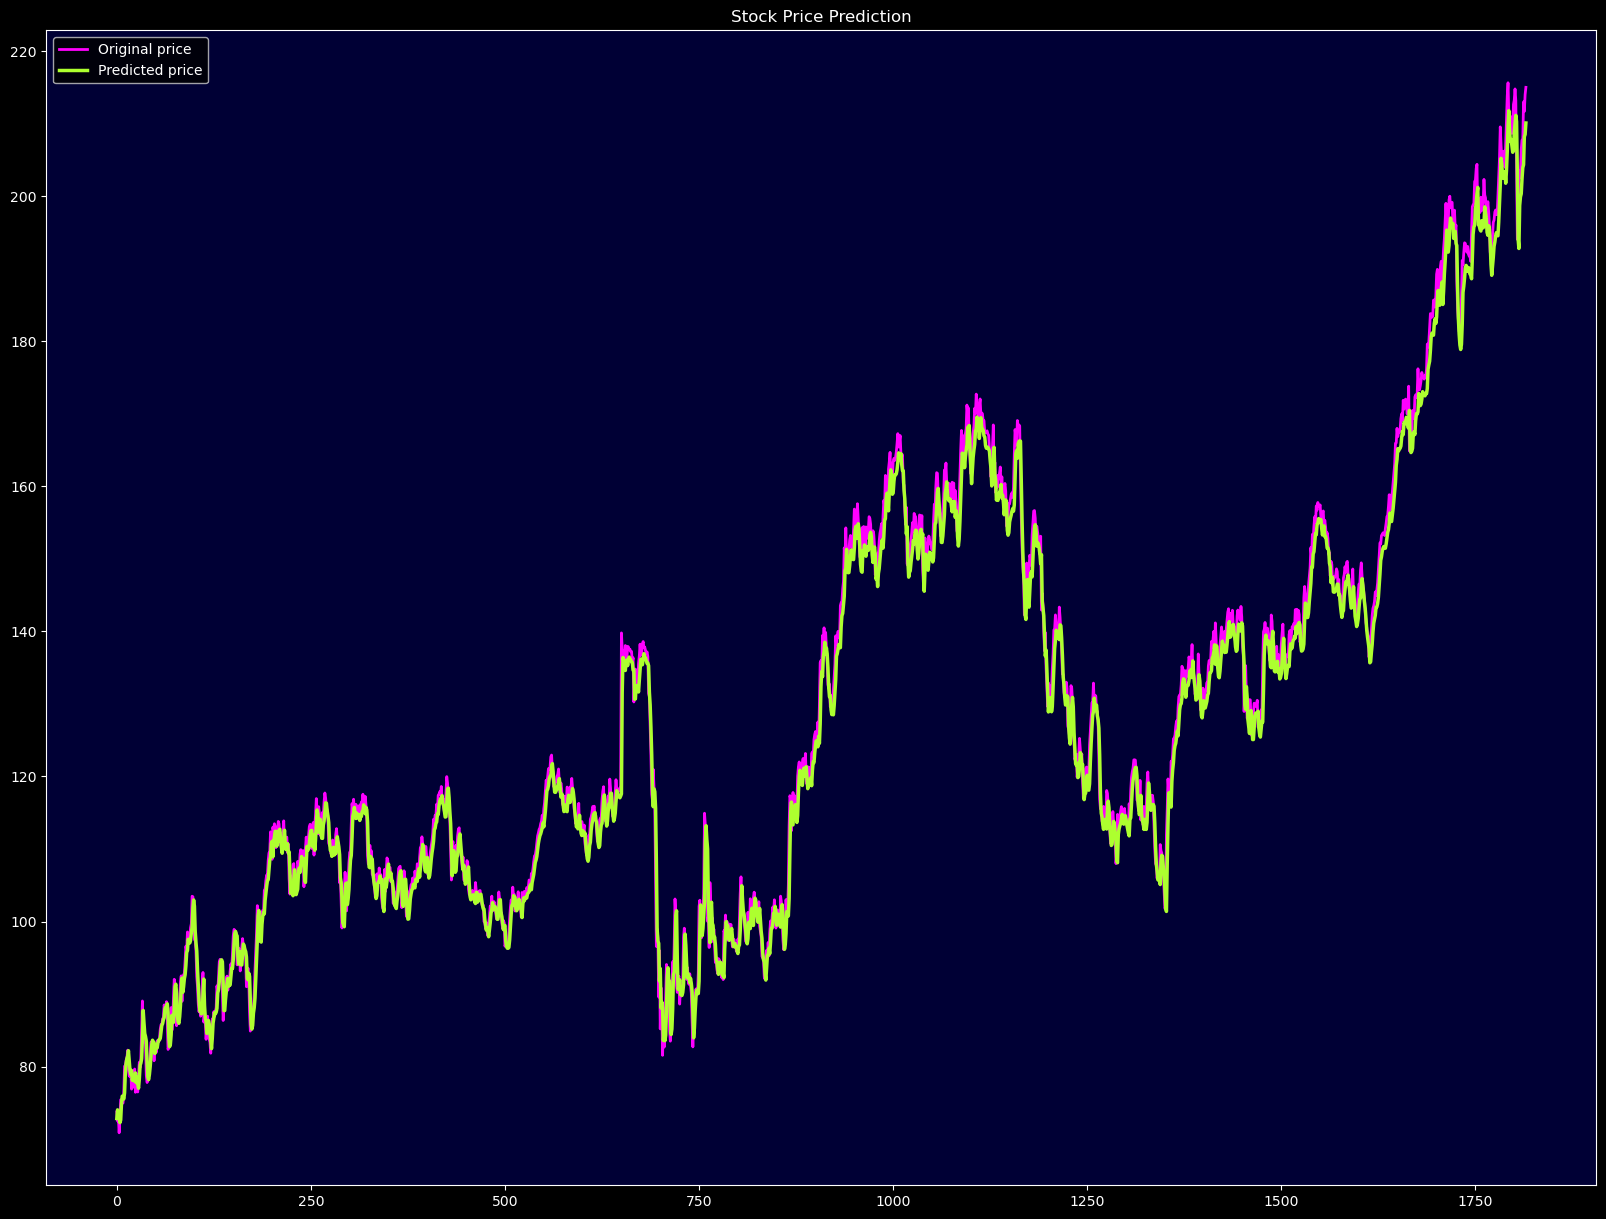

In [79]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(20,15))
ax.set_facecolor('#000035')
ax.plot(y_test_scaled, color='fuchsia', linewidth=2, label='Original price')
plt.plot(predictions, color='greenyellow', linewidth=2.5, label='Predicted price')
plt.title('Stock Price Prediction')
plt.legend();

In [80]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional

# Define a new Multi-Layer LSTM model
multi_lstm_model = Sequential()

# First LSTM Layer (Bidirectional)
multi_lstm_model.add(Bidirectional(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1))))
multi_lstm_model.add(Dropout(0.2))

# Second LSTM Layer
multi_lstm_model.add(LSTM(units=128, return_sequences=True))
multi_lstm_model.add(Dropout(0.3))

# Third LSTM Layer
multi_lstm_model.add(LSTM(units=64, return_sequences=False))  # Last layer doesn't return sequences
multi_lstm_model.add(Dropout(0.3))

# Fully Connected Dense Layer
multi_lstm_model.add(Dense(units=1))  # Output layer for predicting stock price

# Compile the model
multi_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Model Summary
# multi_lstm_model.summary()

# Training the Multi-Layer LSTM Model
epochs = 20
batch_size = 256

history = multi_lstm_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=1)

# Save the Multi-Layer LSTM Model
multi_lstm_model.save('multi_lstm_stock_prediction.keras')


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 475ms/step - loss: 0.0360 - val_loss: 0.0017
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 517ms/step - loss: 0.0032 - val_loss: 1.2832e-04
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 444ms/step - loss: 0.0025 - val_loss: 1.1601e-04
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 449ms/step - loss: 0.0022 - val_loss: 1.2238e-04
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 491ms/step - loss: 0.0023 - val_loss: 1.0747e-04
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 440ms/step - loss: 0.0022 - val_loss: 1.0164e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - loss: 0.0020 - val_loss: 9.6509e-05
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 534ms/step - loss: 0.0019 - val_loss: 1.4157e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 727ms/step - loss: 0.0018 - val_loss: 1.1252e-04
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 736ms/step - loss: 0.0019 - val_loss: 8.1407e-05
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 781ms/step - loss: 0.0016 - val_loss: 8.2028e-05
E

In [81]:
multi_lstm_model = load_model('multi_lstm_stock_prediction.keras')

In [82]:
# Make Predictions
multi_lstm_predictions = multi_lstm_model.predict(x_test)

# Inverse Transform Predictions and Original Values
multi_lstm_predictions = scaler.inverse_transform(multi_lstm_predictions)
y_test_scaled1 = scaler.inverse_transform(y_test.reshape(-1, 1))

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step


In [83]:
mse = mean_squared_error(y_test_scaled1, multi_lstm_predictions)
print(f"Mean Squared Error (MSE): {mse}")

mae = mean_absolute_error(y_test_scaled1, multi_lstm_predictions)
print(f"Mean Absolute Error (MAE): {mae}")

r2 = r2_score(y_test_scaled1, multi_lstm_predictions)
print(f"R² Score: {r2}")

# Calculate accuracy with a tolerance level
tolerance = 0.10  # 10%

accuracy = np.mean(np.abs((y_test_scaled1 - multi_lstm_predictions) / y_test_scaled1) <= tolerance)
print(f"Accuracy within {tolerance*100}% tolerance: {accuracy * 100:.2f}%")


Mean Squared Error (MSE): 15.086698309723372
Mean Absolute Error (MAE): 3.003214289963508
R² Score: 0.9838978269059193
Accuracy within 10.0% tolerance: 99.34%


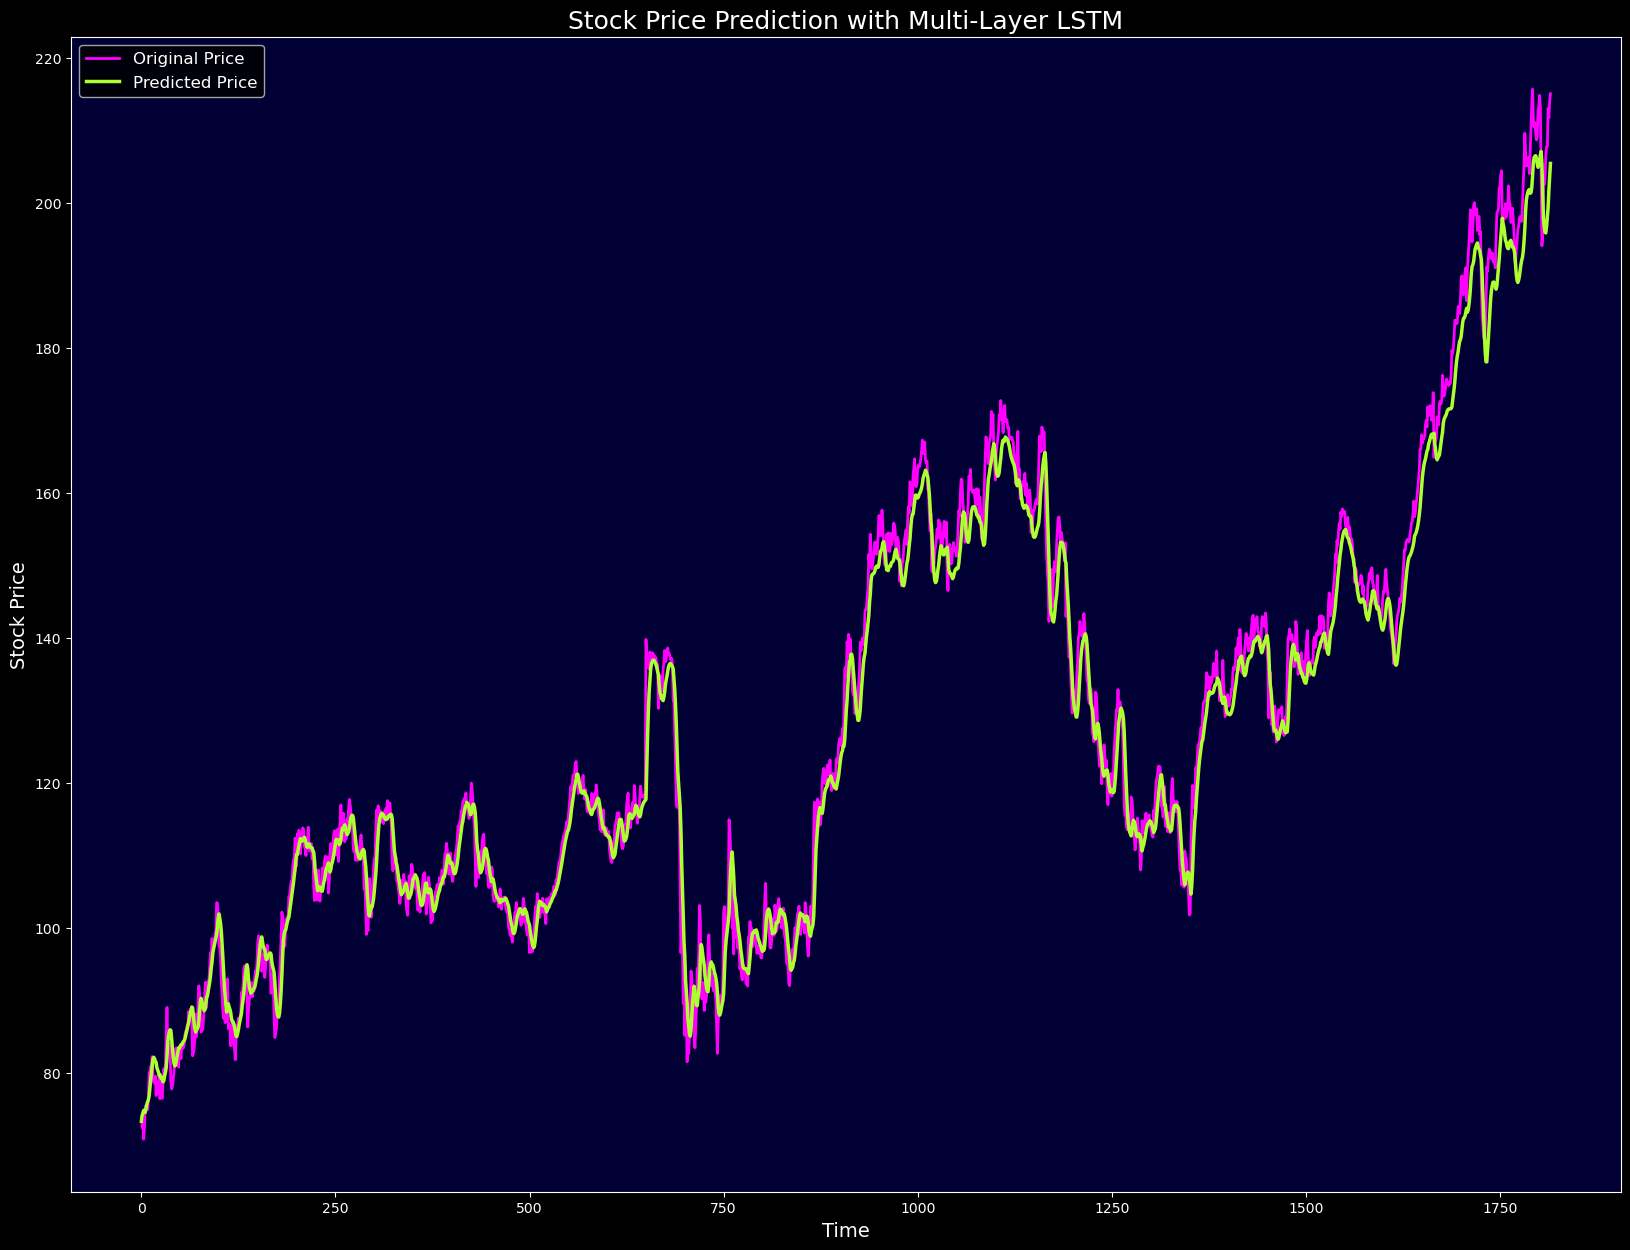

In [84]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(20, 15))
ax.set_facecolor('#000035')

ax.plot(y_test_scaled, color='fuchsia', linewidth=2, label='Original Price')  # Original prices
ax.plot(multi_lstm_predictions, color='greenyellow', linewidth=2.5, label='Predicted Price')  # Predicted prices

plt.title('Stock Price Prediction with Multi-Layer LSTM', fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Stock Price', fontsize=14)

plt.legend(fontsize=12)
plt.show()
